In [1]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


/home/hadoop/miniconda2/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/hadoop/miniconda2/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/hadoop/miniconda2/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/hadoop/miniconda2/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/hadoop/miniconda2/lib/python2.7/site-packages/pandas/core/indexes/bas

In [2]:
import lightgbm as lgb

In [3]:
if 0:
    sys.path.insert(0,os.getcwd()+"/../../src/main")
else:
    sys.path.insert(0, "/mnt/lanlep2019/src/main")
    os.environ['LOCAL']="/mnt/local"

In [4]:
!echo $LOCAL

/mnt/local


In [5]:
!mkdir -p $LOCAL/sandbox

In [6]:
HOME=os.environ['LOCAL']+"/sandbox"
os.chdir(HOME)
os.getcwd()

'/mnt/local/sandbox'

In [7]:
os.environ['LANLEP_HOME']=HOME

In [8]:
import data, utils, config

In [11]:
if 0:
    !ls /home/lizhen09/lanlep2019/input/feat/*.parq | grep -v offset_.parq | xargs -L1  -IINPUT cp INPUT {HOME}/input/feat/
else:
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmp.tar | tar xf - 
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmppkl.tar | tar xf -     

In [12]:
if 1:
    !cd {HOME}/input/ && cp /mnt/lizhen-east2/notebook/fastseq/5/train.parq .

In [9]:
logger=utils.get_logger("test")

In [10]:
if 1:
        fpath = config.TRAIN_PARQ
        assert utils.file_exists(fpath), fpath
        logger.info("read "+fpath)
        df = fastparquet.ParquetFile(fpath).to_pandas()
        logger.info("\n%s", df.head())
        
        a = np.diff(df.time_to_failure.values, 1)
        b = a[a > 2]
        logger.info("quake durations: " + str(b))
        logger.info("mean quake durations: " + str(np.mean(b)))
        logger.info("median quake durations: " + str(np.median(b)))
        logger.info("max quake durations: " + str(np.max(b)))
        logger.info("min quake durations: " + str(np.min(b)))
        
        pos = list(np.where(a > 2)[0])
        logger.info("quakes delimit at " + str(pos))
        for u in pos:
            assert (df.iloc[u]['time_to_failure'] < 0.01) and (df.iloc[u + 1]['time_to_failure'] > 2), "pos " + str(u)  
        
        pos = [0] + pos + [len(df)]
        quakes = []
        for i in range(len(pos) - 1):
            u = pos[i] + 1
            v = pos[i + 1] + 1
            quakes.append(df.iloc[u:v].reset_index(drop=True))
        logger.info("quake duration by 4M hz: " + str(np.round([len(u) * 1.0 / 4000000 for u in quakes], 3)))

#         for i, q in enumerate(quakes):
#             s = q.acoustic_data
#             idx = np.where(s > s.max() * 0.8)[0].max()
#             logger.info("quake {}, max signal={}, len={}, max_sig_time={}".format(i, s.max(), (len(s) - idx), q.iloc[idx]['time_to_failure']))

#         for i, q in enumerate(quakes):
#             outfname = os.path.join(config.INPUT_PATH, "quake_{}.parq".format(i))
#             logger.info("write {}".format(outfname))
#             logger.info("\n%s", q.head())
#             fastparquet.write(outfname, q , compression='SNAPPY')


2019-04-17 09:46:51,063 - test - INFO - read /mnt/local/sandbox/input/train.parq
2019-04-17 09:47:03,843 - test - INFO - 
   acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691
2019-04-17 09:47:04,697 - test - INFO - quake durations: [11.540005  14.179905   8.855905  12.692904   8.054905   7.0579047
 16.106905   7.9049044  9.636905  11.425904  11.024005   8.828005
  8.565905  14.750904   9.458905  11.618005 ]
2019-04-17 09:47:04,698 - test - INFO - mean quake durations: 10.731367
2019-04-17 09:47:04,700 - test - INFO - median quake durations: 10.330455
2019-04-17 09:47:04,701 - test - INFO - max quake durations: 16.106905
2019-04-17 09:47:04,702 - test - INFO - min quake durations: 7.0579047
2019-04-17 09:47:05,367 - test - INFO - quakes delimit at [5656573, 50085877, 104677355, 138772452, 187641819, 218652629, 245829584, 307838916, 338276

In [11]:
df['rt']=df.index[::-1]

In [12]:
df['cumpower2']=(df['acoustic_data'].iloc[::-1]**2).cumsum()[::-1]

In [13]:
df['power2']=df['acoustic_data']**2

In [14]:
df.head()

acoustic_data  time_to_failure         rt    cumpower2  power2
0             12           1.4691  629145479  85363086056     144
1              6           1.4691  629145478  85363085912      36
2              8           1.4691  629145477  85363085876      64
3              5           1.4691  629145476  85363085812      25
4              8           1.4691  629145475  85363085787      64

In [15]:
delimits = dict(enumerate([u +1 for u in pos]))
del delimits[0],delimits[17],delimits[16]
str(delimits)

'{1: 5656574, 2: 50085878, 3: 104677356, 4: 138772453, 5: 187641820, 6: 218652630, 7: 245829585, 8: 307838917, 9: 338276287, 10: 375377848, 11: 419368880, 12: 461811623, 13: 495800225, 14: 528777115, 15: 585568144}'

In [16]:
lst=[]
for i in range(1,15):
    a=df.iloc[delimits[i]]['time_to_failure']
    b=delimits[i+1]-delimits[i]
    print a/b
    lst.append(a/b)
tick_per_sec=np.mean(lst)    
print 'mean', tick_per_sec

2.597564907747484e-07
2.597584950222597e-07
2.59764620805815e-07
2.5975372760896666e-07
2.597642573837181e-07
2.597421239891956e-07
2.597576908934455e-07
2.5973334985753926e-07
2.5974918466979224e-07
2.597438538070975e-07
2.597428832404429e-07
2.597370790498466e-07
2.597576661941502e-07
2.597558072672897e-07
mean 2.597512307545933e-07


In [17]:
da=df['acoustic_data'].values
df.iloc[np.where(da>4000)]['time_to_failure'].describe()

count    35.000000
mean      0.316252
std       0.003373
min       0.311198
25%       0.314698
50%       0.315497
75%       0.320300
max       0.320300
Name: time_to_failure, dtype: float64

In [18]:
zero_failure_to_peak_sec=0.315497

In [19]:
dt = -df['time_to_failure'].diff(1)

In [20]:
np.where(dt>1)

(array([], dtype=int64),)

In [21]:
dt.mean(),dt.median()

(-1.31777504e-08, 0.0)

In [22]:
a=dt[dt>=0]
a=a[a<1]
a.mean(),a.median()

(2.5972275e-07, 0.0)

In [23]:
df['power2'].mean(),df['power2'].median()

(135.6809971137359, 25.0)

In [24]:
a=df['power2'][df['power2']<1000**2]
a.mean(),a.median()

(83.73878680308145, 25.0)

In [25]:
#k1-25=k2*2.5972275e-07

In [26]:
#k2=-(132.702223-25)/2.5972275e-07
#k2

In [27]:
if 1:
    a = fastparquet.ParquetFile("./input/feat/dense_train_seq_fwv_offset_0.parq").to_pandas()
    b = fastparquet.ParquetFile("./input/feat/dense_train_seq_fwv_offset_125.parq").to_pandas()
    traintest=(a+b)/2

In [28]:
traintest.sort_index().head()

fwv_0     fwv_1     fwv_2     fwv_3     fwv_4  \
index                                                                    
quake_00_0000_000000  0.216542  0.185661  0.108143 -0.078809  0.072412   
quake_00_0000_001500  0.216926  0.186926  0.107084 -0.078361  0.072662   
quake_00_0000_003000  0.218769  0.185365  0.107872 -0.077107  0.068210   
quake_00_0000_004500  0.217223  0.187727  0.107976 -0.075922  0.069759   
quake_00_0000_006000  0.217587  0.189069  0.109821 -0.078284  0.067517   

                         fwv_5     fwv_6     fwv_7     fwv_8     fwv_9  \
index                                                                    
quake_00_0000_000000 -0.139160 -0.031245  0.159314  0.176967  0.008096   
quake_00_0000_001500 -0.141274 -0.032242  0.155919  0.177656  0.008914   
quake_00_0000_003000 -0.144663 -0.027850  0.152220  0.177217  0.014360   
quake_00_0000_004500 -0.149111 -0.028620  0.147861  0.177286  0.021192   
quake_00_0000_006000 -0.148003 -0.027025  0.151348  0.174712  0.022093   

                        ...       fwv_91    fwv_92    fwv_93    fwv_94  \
index                   ...                                              
quake_00_0000_000000    ...     0.211306  0.132915  0.057632 -0.069395   
quake_00_0000_001500    ...     0.212022  0.133815  0.060779 -0.068313   
quake_00_0000_003000    ...     0.213136  0.137043  0.060594 -0.067772   
quake_00_0000_004500    ...     0.210489  0.139401  0.061828 -0.065347   
quake_00_0000_006000    ...     0.209734  0.137879  0.058090 -0.065387   

                        fwv_95    fwv_96    fwv_97    fwv_98    fwv_99  \
index                                                                    
quake_00_0000_000000  0.011235 -0.035435 -0.102105  0.053612  0.032469   
quake_00_0000_001500  0.015169 -0.034959 -0.099313  0.053454  0.029014   
quake_00_0000_003000  0.017519 -0.036653 -0.097048  0.052951  0.025466   
quake_00_0000_004500  0.015690 -0.038876 -0.095629  0.053188  0.021562   
quake_00_0000_006000  0.018760 -0.038393 -0.095949  0.053929  0.024904   

                             y  
index                           
quake_00_0000_000000  1.430797  
quake_00_0000_001500  1.430796  
quake_00_0000_003000  1.429798  
quake_00_0000_004500  1.429797  
quake_00_0000_006000  1.428700  

[5 rows x 101 columns]

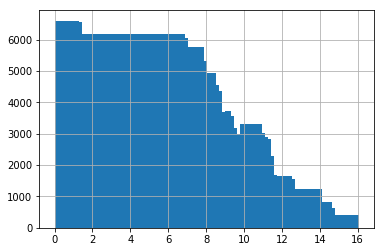

In [29]:
traintest.y.hist(bins=100);

In [30]:
np.abs(traintest.y-traintest.y.median()).mean()

3.02918898210172

In [31]:
traindf=traintest.drop('y',axis=1)
ydf=traintest.y
qdf=traindf.index.map(lambda u: int(u.split("_")[1]))

In [32]:
idx=~qdf.isin({0,16})
traindf=traindf[idx]
ydf=ydf[idx]
qdf=qdf[idx]

In [33]:
def f(u):
    qno, i, offset = [int(x) for x in u.split('_')[1:]]
    return delimits[qno]+offset+(i+0)*150 * 1000
    
globaloffset = pd.Series(traindf.index.map(f), index=traindf.index) 

In [34]:
ydf.shape,traindf.shape

((409394,), (409394, 100))

In [35]:
df.head()

acoustic_data  time_to_failure         rt    cumpower2  power2
0             12           1.4691  629145479  85363086056     144
1              6           1.4691  629145478  85363085912      36
2              8           1.4691  629145477  85363085876      64
3              5           1.4691  629145476  85363085812      25
4              8           1.4691  629145475  85363085787      64

In [36]:
BT0=df.loc[globaloffset.values,'cumpower2'].values

In [37]:
BT0

array([67883408888, 53438798663, 46698136638, ..., 42315947099,
       11489617842, 27264942038])

In [38]:
T0=df.loc[globaloffset.values,'rt'].values

In [39]:
BT0.shape,T0.shape

((409394,), (409394,))

In [40]:
traindf.shape

(409394, 100)

In [141]:
a=(df['power2'].values).copy()
a[a>100000]=100000

In [142]:
%%time
def f(u):
    u=int(u)
    return a[u-150*1000:u].mean()
W=globaloffset.map(f)

CPU times: user 51.3 s, sys: 13.2 ms, total: 51.4 s
Wall time: 51.4 s


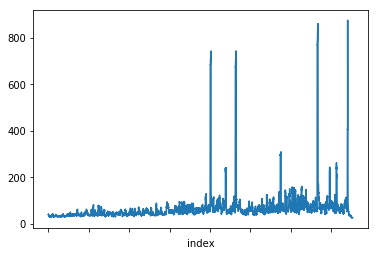

In [143]:
a=W[qdf==14].sort_index()
a=a[a<1000]
a.plot()

In [144]:
H=np.concatenate([traindf.values,np.ones([len(traindf),1]), -T0.reshape([-1,1])*W.values.reshape([-1,1])],axis=1)

In [145]:
H.shape,BT0.shape

((409394, 102), (409394,))

In [146]:
x,residuals,rank,s = np.linalg.lstsq(H, -BT0)

/home/hadoop/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [147]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression().fit(H,-BT0)
reg.score(H,-BT0)

0.18151640516409798

In [148]:
x

array([ 5.30126353e+10, -1.86702481e+10,  1.58998415e+10,  3.64915965e+10,
       -8.54136252e+09, -2.31361475e+10,  7.42752918e+10, -4.93570041e+10,
       -5.42019056e+10, -6.17814216e+10,  5.84718669e+10,  8.51720308e+10,
       -4.28277892e+10,  4.64915607e+09, -6.62709404e+10,  4.32865679e+10,
       -6.23391586e+09,  1.39020796e+11, -4.22675441e+10,  3.68687251e+10,
        1.00887697e+10,  1.97661259e+10, -6.00028758e+10, -2.88839183e+10,
        9.90770369e+08,  2.32851405e+10, -6.11369110e+10,  5.50268864e+10,
       -2.29987002e+10, -2.77638473e+10, -3.94831265e+10, -7.84596037e+10,
       -1.06350403e+10, -4.40433436e+10, -7.15593684e+08, -1.41773041e+10,
        4.13078612e+10,  2.08403878e+10, -1.94981747e+10, -8.41574347e+10,
       -6.71957031e+10,  2.64298953e+09, -3.47245560e+10,  2.82191555e+10,
       -3.38306211e+10, -8.89413040e+10, -3.52508308e+10,  2.77323993e+10,
       -4.93632182e+10,  2.62466115e+10, -1.34535609e+10, -2.01106966e+09,
        5.34577706e+10, -

In [149]:
x.shape

(102,)

In [150]:
alpha_prime=x[:100]
beta_prime=x[100]
k1=x[101]

In [151]:
beta_prime,k1

(-91442323328.39581, 0.0997772216796875)

In [152]:
delimits

{1: 5656574,
 2: 50085878,
 3: 104677356,
 4: 138772453,
 5: 187641820,
 6: 218652630,
 7: 245829585,
 8: 307838917,
 9: 338276287,
 10: 375377848,
 11: 419368880,
 12: 461811623,
 13: 495800225,
 14: 528777115,
 15: 585568144}

In [153]:
tmp=ydf.to_frame().reset_index()
tmp['qno']=qdf
tmp=tmp[tmp['y']>=zero_failure_to_peak_sec]
tmp=tmp.sort_values(['qno','y'])

In [154]:
minsegs = tmp.groupby("qno").head(1).set_index('index')['y']
minsegs

index
quake_01_0287_016500    0.315596
quake_02_0354_129000    0.315696
quake_03_0218_031500    0.315997
quake_04_0316_105000    0.315498
quake_05_0197_097500    0.315996
quake_06_0172_009000    0.316497
quake_07_0404_046500    0.315596
quake_08_0193_120000    0.316196
quake_09_0238_037500    0.315497
quake_10_0284_024000    0.316196
quake_11_0273_126000    0.316096
quake_12_0217_072000    0.316096
quake_13_0210_114000    0.315796
quake_14_0369_078000    0.315596
quake_15_0233_105000    0.315596
Name: y, dtype: float64

In [155]:
k1

0.0997772216796875

In [156]:
k2=k1-135.6809971137359
#k2=k1-83.73878680308145
#k2=k1-25
k2

-135.58121989205623

In [157]:
alpha=alpha_prime/k2
alpha

array([-3.91002791e+08,  1.37705267e+08, -1.17271710e+08, -2.69149344e+08,
        6.29981241e+07,  1.70644190e+08, -5.47828762e+08,  3.64040124e+08,
        3.99774435e+08,  4.55678313e+08, -4.31268187e+08, -6.28199325e+08,
        3.15882902e+08, -3.42905608e+07,  4.88791445e+08, -3.19266694e+08,
        4.59791988e+07, -1.02536912e+09,  3.11750728e+08, -2.71930914e+08,
       -7.44112625e+07, -1.45788081e+08,  4.42560377e+08,  2.13037752e+08,
       -7.30757822e+06, -1.71743111e+08,  4.50924627e+08, -4.05859207e+08,
        1.69630427e+08,  2.04776497e+08,  2.91213831e+08,  5.78690793e+08,
        7.84403645e+07,  3.24848409e+08,  5.27797054e+06,  1.04566872e+08,
       -3.04672441e+08, -1.53711464e+08,  1.43811766e+08,  6.20716016e+08,
        4.95612174e+08, -1.94937731e+07,  2.56116268e+08, -2.08134693e+08,
        2.49522914e+08,  6.56000175e+08,  2.59997888e+08, -2.04544548e+08,
        3.64085957e+08, -1.93585893e+08,  9.92287935e+07,  1.48329515e+07,
       -3.94285953e+08,  

In [158]:
beta_prime

-91442323328.39581

In [159]:
X=np.sum(alpha*traindf.loc[minsegs.index].values,1)
X

array([-4.83692077e+08, -2.98769619e+08, -2.86225055e+08, -2.86580043e+08,
       -3.12344837e+08, -4.83915215e+08, -3.95852650e+08, -4.39469462e+08,
       -3.68661223e+08, -4.28912871e+08, -3.64773054e+08, -3.90117850e+08,
       -3.87308073e+08, -3.32483522e+08, -3.77304411e+08])

In [160]:
beta=-X.mean()
print beta
beta=beta*1.073
print beta

375760664.1608001
403191192.64453846


In [161]:
A=k2*beta-beta_prime
A,k2,k1

(36777169579.916245, -135.58121989205623, 0.0997772216796875)

In [162]:
df.head()

acoustic_data  time_to_failure         rt    cumpower2  power2
0             12           1.4691  629145479  85363086056     144
1              6           1.4691  629145478  85363085912      36
2              8           1.4691  629145477  85363085876      64
3              5           1.4691  629145476  85363085812      25
4              8           1.4691  629145475  85363085787      64

In [163]:
a=(A+df['rt'].loc[globaloffset.values]*k1*W.values-df['cumpower2'].loc[globaloffset.values])/k2/30

In [164]:
b=a.values*tick_per_sec+7

In [165]:
b

array([8.78327335, 7.94258773, 7.50969151, ..., 7.1979397 , 5.36513612,
       6.34056101])

In [166]:
from sklearn.linear_model import LinearRegression

coef [0.02344183] 9.495756809704321
range 1 -0.782876099915101 9.787591835143578 10.57046793505868


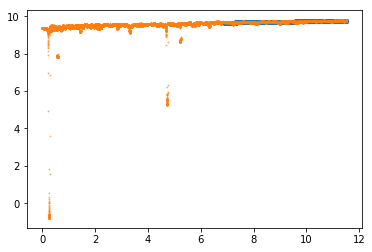

coef [0.02639476] 9.01959614152281
range 2 1.8724975707630067 9.395861392164104 7.523363821401097


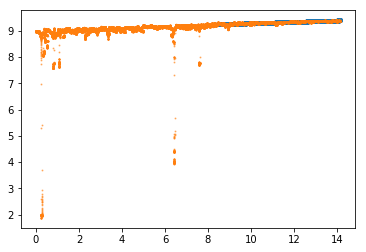

coef [0.02849771] 8.757943530124338
range 3 1.7158277048449415 9.012544920268109 7.296717215423167


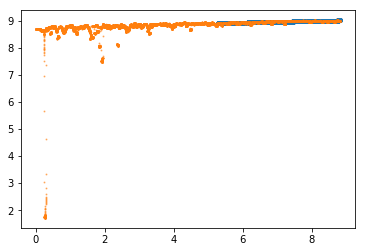

coef [0.02384724] 8.404827671497872
range 4 -0.424665367087238 8.719185405122298 9.143850772209536


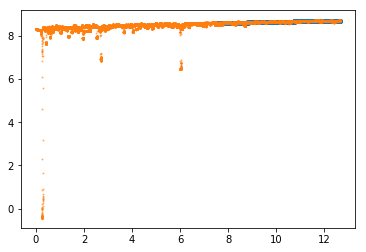

coef [0.01436225] 8.18253008129371
range 5 -0.5590385282594399 8.309641251887037 8.868679780146476


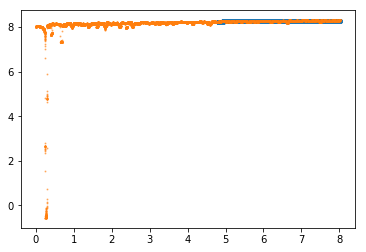

coef [0.0222306] 7.872056360164252
range 6 2.965166219626438 8.046719814502378 5.08155359487594


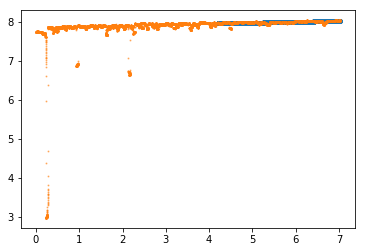

coef [0.02004026] 7.435934179127615
range 7 3.504563780561535 7.767869471276643 4.263305690715107


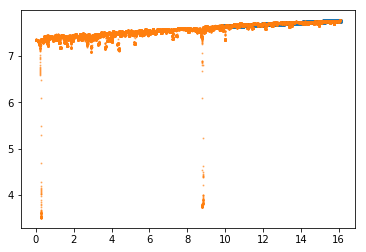

coef [0.01286792] 7.240142865580128
range 8 1.9448332169674556 7.353522647735236 5.40868943076778


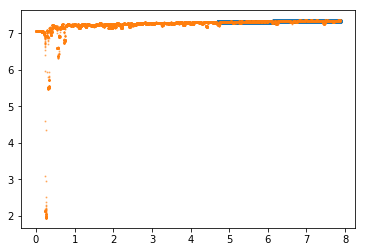

coef [0.01239558] 6.943615087398622
range 9 2.288201571098611 7.070028280086133 4.781826708987522


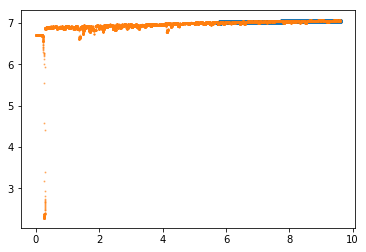

coef [0.01469718] 6.549731141111134
range 10 2.5756964989100686 6.723654789441175 4.147958290531107


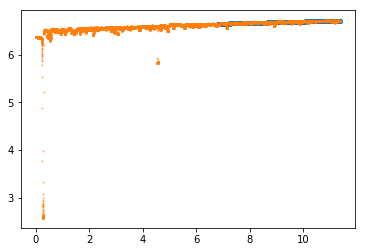

coef [0.0151978] 6.208488443048354
range 11 3.4059108426979967 6.378497731745726 2.972586889047729


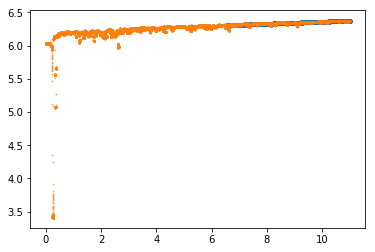

coef [0.01344255] 5.926297908114014
range 12 3.545968843800034 6.04665422966249 2.500685385862456


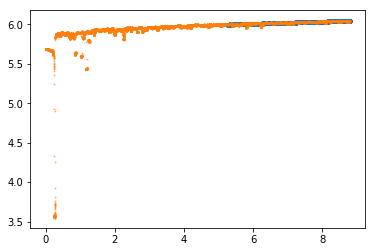

coef [0.00933359] 5.605524247582063
range 13 3.7763450054960215 5.689542307410179 1.913197301914158


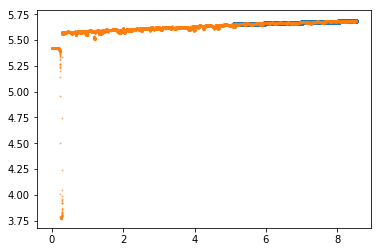

coef [0.01179615] 5.251046367939278
range 14 4.305223337620468 5.425791338648615 1.120568001028147


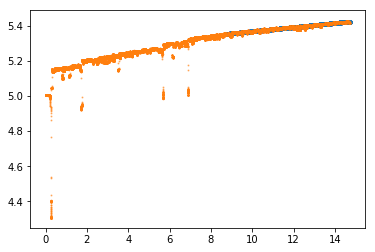

coef [0.00865492] 4.925164038790354
range 15 4.566485799506205 5.006513466654685 0.4400276671484793


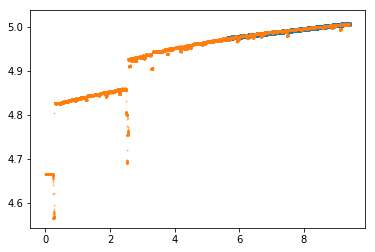

In [167]:
for qno in range(1,16):
    idx=qdf==qno
    bb=b[idx]
    aa=ydf.values[idx]
    if 1:
        sidx=np.argsort(aa)
        bb=bb[sidx]
        aa=aa[sidx]
    if 1:
        n=int(len(aa)*0.4)
        model = LinearRegression().fit(aa[-n:].reshape(-1, 1),bb[-n:])
        print 'coef', model.coef_, model.intercept_
        pbb=model.predict(aa[-n:].reshape(-1, 1))
        plt.scatter(aa[-n:].reshape(-1, 1),pbb,s=11)
    print 'range', qno,bb.min(),bb.max(), bb.max()-bb.min()
    plt.scatter(aa,bb,s=1,alpha=0.5)
    plt.show()

In [168]:
if 0:
    !cd {HOME}/input/ &&   cat /mnt/lizhen-east2/notebook/fastseq/5/trainqs.tar | tar xf - 

In [169]:
def readq(qno):
    return fastparquet.ParquetFile(HOME+"/input/quake_{}.parq".format(qno)).to_pandas()

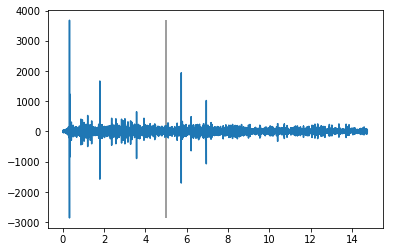

In [170]:
q=readq(14)
plt.plot(q.time_to_failure, q.acoustic_data);
plt.vlines(x=5,ymin=q.acoustic_data.min(), ymax=q.acoustic_data.max(),alpha=0.5);

In [171]:
a=(q['acoustic_data']**2)

In [172]:
a=a[a<1000]

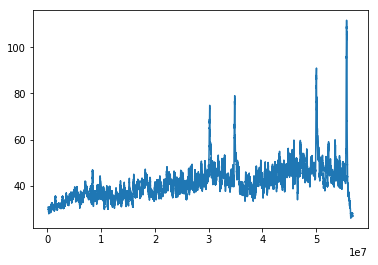

In [173]:
a.rolling(150*1000).mean().plot()

In [174]:
b=np.sum(traindf.values*alpha,1)+beta
b=b*tick_per_sec/25+8

1


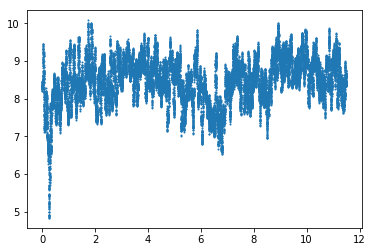

2


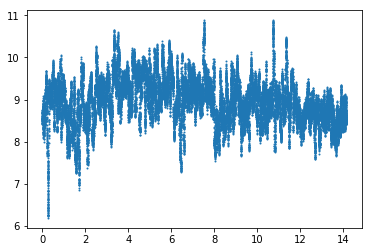

3


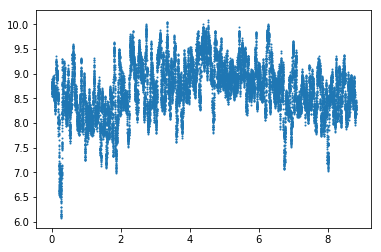

4


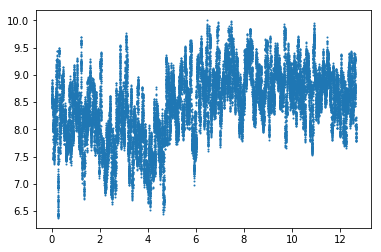

5


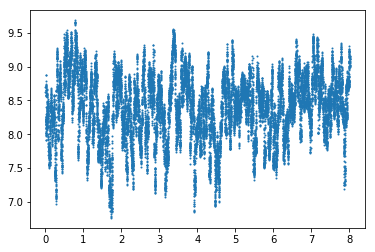

6


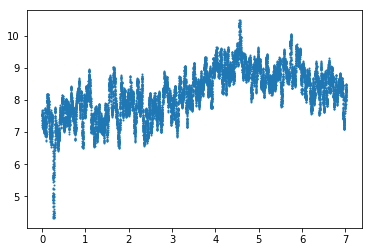

7


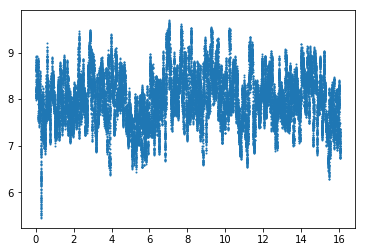

8


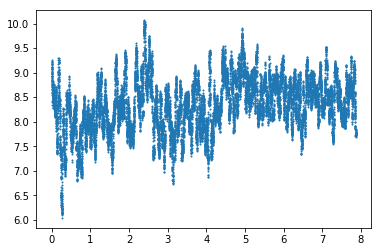

9


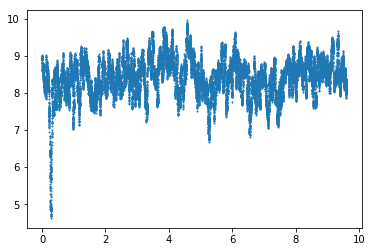

10


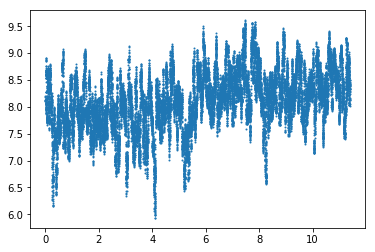

11


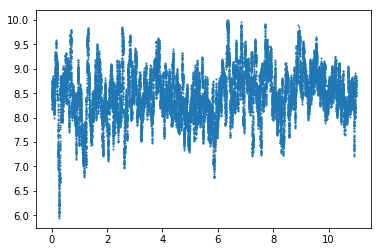

12


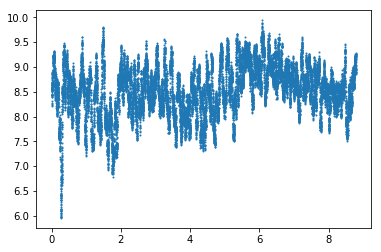

13


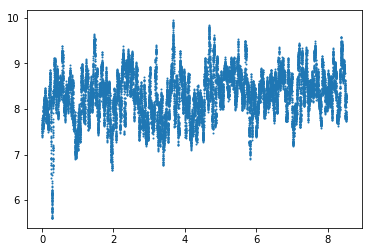

14


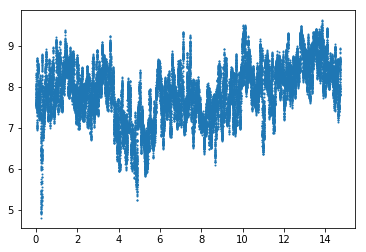

15


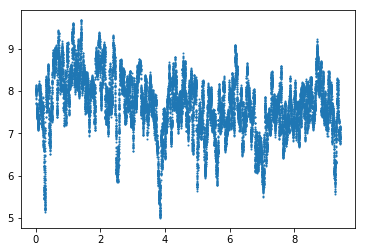

In [175]:
for qno in range(1,16):
    idx=qdf==qno
    print qno
    plt.scatter(ydf.values[idx],b[idx],s=1)
    plt.show()

In [176]:
import gc
gc.collect()

4200

In [45]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso


In [122]:
reg = LinearRegression(fit_intercept=False).fit(H,BT0)


In [121]:
reg.score(H,BT0)

0.9994258605930015

In [119]:
reg.score(H,BT0)

0.9994258605929971

In [116]:
reg.intercept_

5335697564.480194

In [108]:
residuals[0]

1.3103301300606225e+23

In [112]:
1.3103301300606225e+23/np.sum((BT0-BT0.mean())**2)

0.000574139406994869

((409394, 102), (409394,))

In [48]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [49]:
colors= [
        "FF0000", "00FF00", "0000FF", "FF00FF", "00FFFF", "000000", 
        "800000", "008000", "000080", "808000", "800080", "008080", "808080", 
        "C00000", "00C000", "0000C0", "C0C000", "C000C0", "00C0C0", "C0C0C0", 
        "400000", "004000", "000040", "404000", "400040", "004040", "404040", 
        "200000", "002000", "000020", "202000", "200020", "002020", "202020", 
        "600000", "006000", "000060", "606000", "600060", "006060", "606060", 
        "A00000", "00A000", "0000A0", "A0A000", "A000A0", "00A0A0", "A0A0A0", 
        "E00000", "00E000", "0000E0", "E0E000", "E000E0", "00E0E0", "E0E0E0", 
    ]
colors=[np.array([int(h[i:i+2], 16)/255.0 for i in (0, 2 ,4)]) for h in colors]

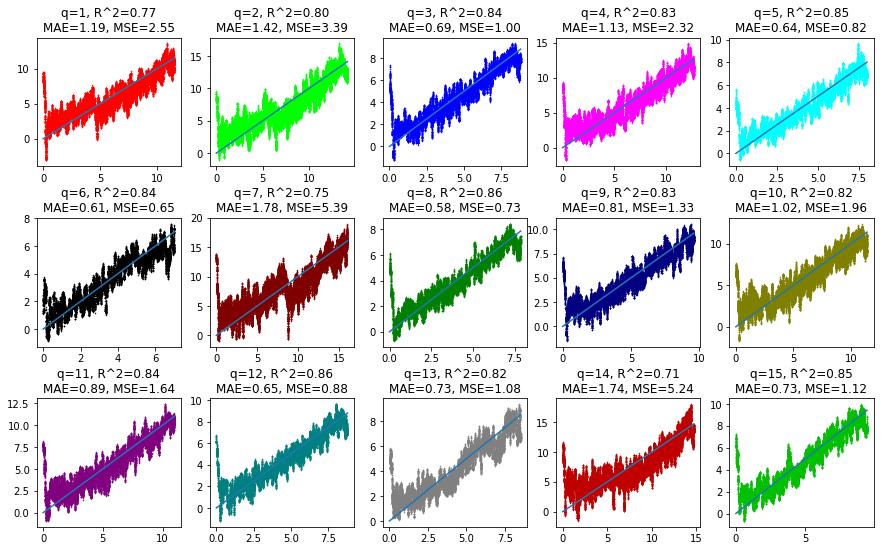

In [50]:
fig, axs = plt.subplots(figsize=(15,9), 
                        nrows=3, ncols=5,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

references=sorted(set(qdf))

for ax, (i,qno) in zip(axs.flatten(), enumerate(references)):
    X=traindf[qdf==qno]
    Y=ydf[qdf==qno]
    reg = Ridge().fit(X,Y)
    x,y=Y,reg.predict(X)
    ax.scatter(x.values,y,s=0.3,c=colors[i])
    b=sorted(x.values)
    ax.plot(b,b)
    ax.set_title('q={}, R^2={:.2f}\nMAE={:.2f}, MSE={:.2f}'.format(qno,r2_score(x,y), mean_absolute_error(x,y)
                                                                   ,mean_squared_error(x,y)))
    

In [41]:
#! cd /mnt && tar xf /mnt/lizhen-east2/notebook/fastseq/5/trainqs.tar

In [35]:
def readq(qno):
    return fastparquet.ParquetFile("/mnt/quake_{}.parq".format(qno)).to_pandas()

In [58]:
q=readq(14)

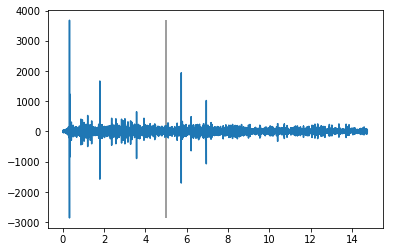

In [59]:
plt.plot(q.time_to_failure, q.acoustic_data);
plt.vlines(x=5,ymin=q.acoustic_data.min(), ymax=q.acoustic_data.max(),alpha=0.5);

In [42]:
reg = LinearRegression().fit(traindf, ydf)

In [43]:
reg.score(traindf,ydf)

0.47749277921675126

In [44]:
trainpred=reg.predict(traindf)

In [45]:
err=ydf.values-trainpred
np.sqrt(np.mean(err*err)),np.sqrt(np.median(np.abs(err)))

(2.6242166651851453, 1.3087841294000262)

In [46]:
a=ydf.copy().to_frame()
a['pred']=trainpred
a['abserr']=np.abs(a['pred']-a['y'])
a['qno']=a.index.map(lambda u: int(u.split("_")[1]))

In [47]:
a.groupby('qno')['abserr'].apply(lambda u: np.sqrt(np.mean(u.values**2))).sort_values()

qno
11    1.631354
9     1.644194
10    1.805674
12    1.875820
1     1.888808
3     1.897652
15    2.231170
13    2.233907
4     2.364902
5     2.658899
8     2.727387
6     2.837420
2     3.057987
14    3.505263
7     4.003069
Name: abserr, dtype: float64

In [48]:
a.groupby('qno')['abserr'].apply(lambda u:  np.mean(u.values)).sort_values()

qno
9     1.134728
11    1.205874
10    1.388971
3     1.443394
12    1.443830
1     1.481676
15    1.782918
13    1.812713
4     1.998983
5     2.332561
8     2.474056
6     2.487523
2     2.559095
14    2.991004
7     3.303495
Name: abserr, dtype: float64

In [49]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [50]:
colors= [
        "FF0000", "00FF00", "0000FF", "FF00FF", "00FFFF", "000000", 
        "800000", "008000", "000080", "808000", "800080", "008080", "808080", 
        "C00000", "00C000", "0000C0", "C0C000", "C000C0", "00C0C0", "C0C0C0", 
        "400000", "004000", "000040", "404000", "400040", "004040", "404040", 
        "200000", "002000", "000020", "202000", "200020", "002020", "202020", 
        "600000", "006000", "000060", "606000", "600060", "006060", "606060", 
        "A00000", "00A000", "0000A0", "A0A000", "A000A0", "00A0A0", "A0A0A0", 
        "E00000", "00E000", "0000E0", "E0E000", "E000E0", "00E0E0", "E0E0E0", 
    ]
colors=[np.array([int(h[i:i+2], 16)/255.0 for i in (0, 2 ,4)]) for h in colors]

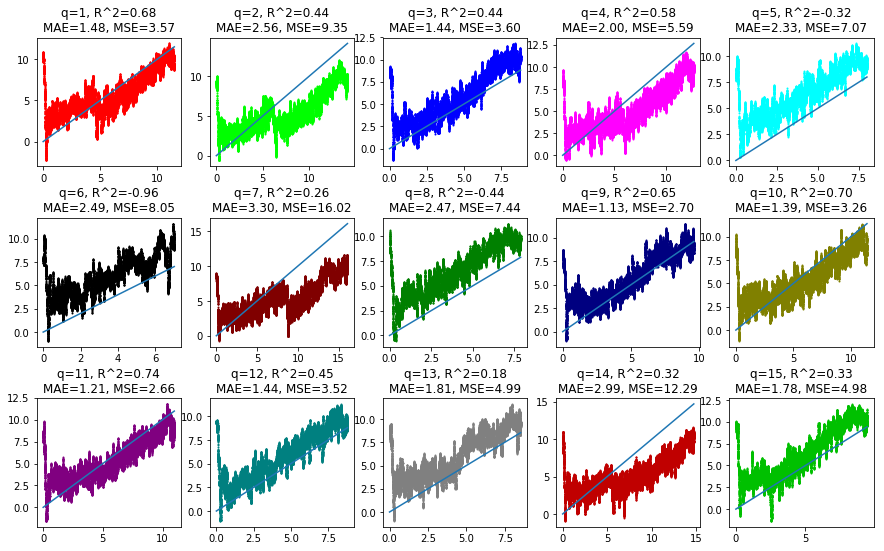

In [51]:
fig, axs = plt.subplots(figsize=(15,9), 
                        nrows=3, ncols=5,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

references=sorted(set(a['qno']))

for ax, (i,qno) in zip(axs.flatten(), enumerate(references)):
    x,y=a[a['qno']==qno]['y'],a[a['qno']==qno]['pred']
    ax.scatter(x,y,s=1,c=colors[i])
    b=sorted(x.values)
    ax.plot(b,b)
    ax.set_title('q={}, R^2={:.2f}\nMAE={:.2f}, MSE={:.2f}'.format(qno,r2_score(x,y), mean_absolute_error(x,y)
                                                                   ,mean_squared_error(x,y)))
    